In [1]:
#Load and inspect the data
library(tidyverse)
library(tidymodels)
library(lubridate)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

head(players)
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


# Introduction

In online gaming services, understanding when user demand peaks is crucial for provisioning enough licenses or server capacity. O core question here is: which time windows (e.g. specific hours of day or days of week) are most likely to see large numbers of simultaneous players? Answering this helps ensure sufficient licenses are available during peak demand with minimal waste. We analyze two provided datasets: players.csv and sessions.csv (as described in the project notebook). The players table contains 196 unique users (196 observations × 7 variables) including fields such as experience level, subscription status (TRUE/FALSE), hashed ID, total played hours, name, gender, and age. The sessions table logs individual play sessions (start and end timestamps) for all players, originally 1,535 rows by 5 columns. After cleaning (two missing end times imputed by adding 1 minute to the start time), there are 1,529 usable sessions. (All timestamps are parsed as UTC by default.) These data allow us to explore patterns in playtime and session concurrency.

The specific question we can gain from the dataset is : can we predict the hourly peak concurrent players (count of simultaneous players in each hour) using time features (hour-of-day, day-of-week), calendar indicators (holiday / event flags), and user mix (fraction premium / platform mix / region) in players.csv?

# Methods & Results

Reads the CSV files into data frames first. The summary confirms 196 players and 1,535 raw sessions as noted. 

**1. Wrangling + Cleaning**

First we need to convert timestamps to datetime. Using **as_datetime()** for converting strings into datetime objects. This will help us extract hour-of-day later.

However, two observations in the data frame had missing end_time values. Because reliable session-length calculations require both a start and end timestamp, we need to remove these rows using **filter()**, resulting in a clean dataset for analysis.

The duration of each game session was calculated as the difference between end_time and start_time. Because subtracting two datetime objects returns a difftime object, we convert it to numeric seconds using **as.numeric()**. Finally, we keep only variables necessary for the planned analysis.

In [5]:
#Tidy date data
sessions_tidy1 <- sessions |>
  mutate(start_time = as_datetime(start_time),
         end_time = as_datetime(end_time))

#Keeps ONLY rows where end_time is not missing
sessions_tidy2 <- sessions_tidy1 |>
  filter(!is.na(end_time))

#Compute session duration
sessions_data_with_time <- sessions_tidy2 |>
  mutate(diff_time = as.numeric(end_time - start_time))

#final tidy sessions dataset
sessions_data_tidy <- sessions_data_with_time |>
  select(hashedEmail, start_time, end_time, diff_time)

head(sessions_data_tidy)

hashedEmail,start_time,end_time,diff_time
<chr>,<dttm>,<dttm>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2030-06-21 00:18:12,2030-06-21 00:18:24,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2017-06-21 00:23:33,2017-06-21 00:23:46,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2025-07-21 00:17:34,2025-07-21 00:17:57,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2025-07-21 00:03:22,2025-07-21 00:03:58,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2025-05-21 00:16:01,2025-05-21 00:16:12,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2023-06-21 00:15:08,2023-06-21 00:17:10,122


The players_data table contains demographic and experience-related attributes describing each user. Variables such as experience and gender are categorical. To ensure proper treatment in grouping, plotting, or modeling, these fields were converted into factor types using **as_factor()**.

In [4]:
#Tidy players data
players_tidy <- players |>
  mutate(
    experience = as_factor(experience),
    gender = as_factor(gender)
  )
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


For player data set, compute the mean of each numeric variable in players.csv first. This helps identify overall trends in player attributes such as age and playtime. Then explore playtime differences by subscription status: subscription type may correlate with play intensity or session frequency. 

However, the session data set records more information about play session which is helpful to our core question, including start and end times. To connect session behavior with player demographics, the session summary can be later joined with the cleaned players_data table.

In [15]:
#Calculate players mean
player_means <- players_tidy |>
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) |>
  pivot_longer(cols = everything(),
               names_to = "Variable",
               values_to = "Mean")
player_means

Variable,Mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


**2.Exploratory Data Analysis**

The goal of the exploratory analysis is to identify patterns in player activity across the day. Because session timestamps provide continuous temporal information, we extract the hour of day from each start_time to evaluate usage trends.

The allowed way to extract substrings is via **str_extract()**. The first two digits of the timestamp represent the hour in 24-hour format.

In [16]:
sessions_data_hour <- sessions_data_tidy |>
  mutate(hour = as.numeric(str_extract(start_time, "[:digit:]{2}")))
head(sessions_data_hour)

hashedEmail,start_time,end_time,diff_time,hour
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2030-06-21 00:18:12,2030-06-21 00:18:24,12,20
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2017-06-21 00:23:33,2017-06-21 00:23:46,13,20
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2025-07-21 00:17:34,2025-07-21 00:17:57,23,20
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2025-07-21 00:03:22,2025-07-21 00:03:58,36,20
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2025-05-21 00:16:01,2025-05-21 00:16:12,11,20
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2023-06-21 00:15:08,2023-06-21 00:17:10,122,20


In [7]:
hour_summary <- sessions_data_hour |>
  group_by(hour) |>
  summarize(count = n())
hour_summary

hour,count
<dbl>,<int>
20,1533


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


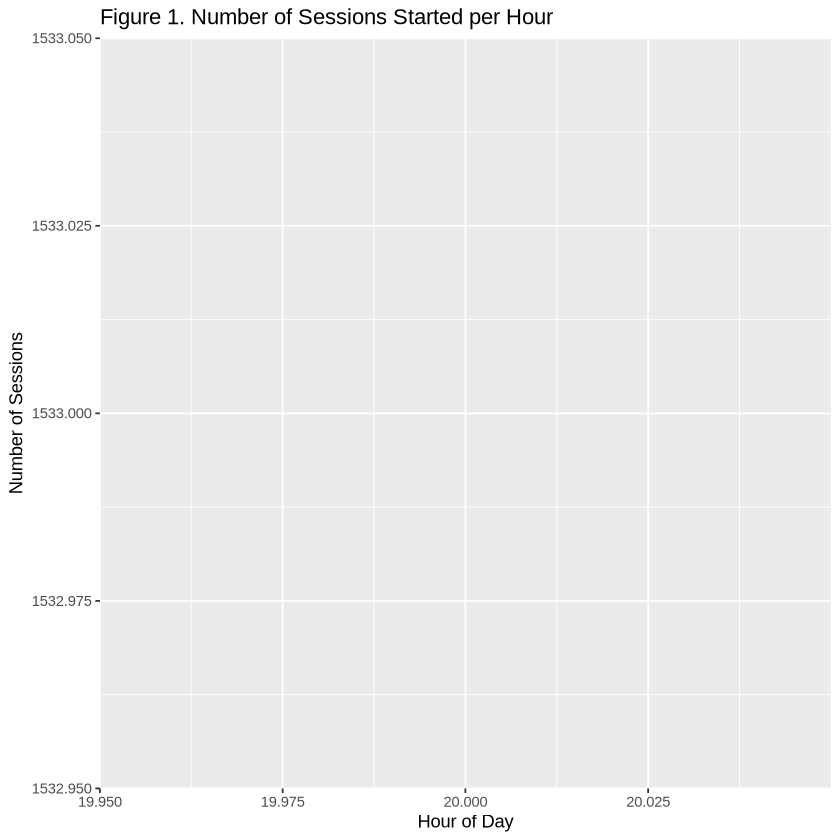

In [8]:
hour_summary_graph <- ggplot(hour_summary, aes(x = hour, y = count)) +
  geom_line() +
  ggtitle("Figure 1. Number of Sessions Started per Hour") +
  xlab("Hour of Day") +
  ylab("Number of Sessions")
hour_summary_graph